In [10]:
import os; os.environ['CUDA_VISIBLE_DEVICES'] = '2'
import math
import collections
from pathlib import Path
import numpy as np
import torch
from torchvision.datasets import EMNIST, MNIST, SVHN, FashionMNIST, CIFAR10
from torchvision.models import alexnet, AlexNet_Weights, resnet18, ResNet18_Weights
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt; plt.style.use('bmh')

In [11]:
root = Path('../data/')
download = True

# ds = SVHN(root=root, download=download) 
mnist_buyer = MNIST(root=root, train=False, download=download)
mnist_seller = MNIST(root=root, train=True, download=download)
fashion = FashionMNIST(root=root, train=False, download=download)
cifar = CIFAR10(root=root, train=False, download=download)
emnist = EMNIST(root=root, split='byclass', train=False, download=download)

Files already downloaded and verified


In [12]:
def subset(dataset, classes):
    class_mask = {k: np.array(dataset.targets) == v for k, v in dataset.class_to_idx.items()}
    dummy = np.array([False] * len(dataset))
    for c in classes:
        dummy ^= class_mask[c]
    return dummy

In [165]:
buyer_index = subset(mnist_buyer, ('0 - zero', '1 - one', '2 - two', '3 - three', '4 - four'))
seller1_index = subset(mnist_seller, ('0 - zero', '1 - one', '2 - two', '3 - three', '4 - four'))
seller2_index = subset(mnist_seller, ('1 - one', '2 - two', '3 - three', '4 - four', '5 - five'))
seller3_index = subset(mnist_seller, ('2 - two', '3 - three', '4 - four', '5 - five', '6 - six'))
seller4_index = subset(mnist_seller, ('3 - three', '4 - four', '5 - five', '6 - six', '7 - seven'))
seller5_index = subset(mnist_seller, ('4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight'))
seller6_index = subset(mnist_seller, ('5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine'))
seller7_index = subset(mnist_seller, ('0 - zero', ))
seller8_index = subset(mnist_seller, ('5 - five', ))
seller9_index = subset(mnist_seller, ('0 - zero', '5 - five'))
seller10_index = subset(mnist_seller, ('0 - zero', '1 - one', '5 - five', '6 - six'))
seller11_index = subset(mnist_seller, ('0 - zero', '1 - one', '2 - two', '5 - five', '6 - six', '7 - seven'))
seller12_index = subset(mnist_seller, ('0 - zero', '1 - one', '2 - two', '3 - three', '5 - five', '6 - six', '7 - seven', '8 - eight'))
seller13_index = subset(mnist_seller, ('0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine'))

emnist_index = subset(emnist, ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'))


# num_samples = 100
# num_samples = 1000
buyer_samples = 10000
seller_samples = 10000

buyer_data = (mnist_buyer.data[buyer_index] / 255) [:buyer_samples]
seller1_data = (mnist_seller.data[seller1_index] / 255) [:seller_samples]
seller2_data = (mnist_seller.data[seller2_index] / 255) [:seller_samples]
seller3_data = (mnist_seller.data[seller3_index] / 255) [:seller_samples]
seller4_data = (mnist_seller.data[seller4_index] / 255) [:seller_samples]
seller5_data = (mnist_seller.data[seller5_index] / 255) [:seller_samples]
seller6_data = (mnist_seller.data[seller6_index] / 255) [:seller_samples]
seller7_data = (mnist_seller.data[seller7_index] / 255) [:seller_samples]
seller8_data = (mnist_seller.data[seller8_index] / 255) [:seller_samples]
seller9_data = (mnist_seller.data[seller9_index] / 255) [:seller_samples]
seller10_data = (mnist_seller.data[seller10_index] / 255) [:seller_samples]
seller11_data = (mnist_seller.data[seller11_index] / 255) [:seller_samples]
seller12_data = (mnist_seller.data[seller12_index] / 255) [:seller_samples]
seller13_data = (mnist_seller.data[seller13_index] / 255) [:seller_samples]

seller_fashion_data = (fashion.data / 255) [:seller_samples]
seller_cifar_data = torch.tensor(cifar.data / 255, dtype=torch.float) [:seller_samples]
seller_emnist_data = (emnist.data[emnist_index] / 255) [:seller_samples]

buyer_data_flat = buyer_data.reshape(-1, 28*28) 
seller1_data_flat = seller1_data.reshape(-1, 28*28) 
seller2_data_flat = seller2_data.reshape(-1, 28*28) 
seller3_data_flat = seller3_data.reshape(-1, 28*28) 
seller4_data_flat = seller4_data.reshape(-1, 28*28) 
seller5_data_flat = seller5_data.reshape(-1, 28*28) 
seller6_data_flat = seller6_data.reshape(-1, 28*28) 
seller7_data_flat = seller7_data.reshape(-1, 28*28) 
seller8_data_flat = seller8_data.reshape(-1, 28*28) 
seller9_data_flat = seller9_data.reshape(-1, 28*28) 
seller10_data_flat = seller10_data.reshape(-1, 28*28) 
seller11_data_flat = seller11_data.reshape(-1, 28*28) 
seller12_data_flat = seller12_data.reshape(-1, 28*28) 
seller13_data_flat = seller13_data.reshape(-1, 28*28) 

seller_fashion_data_flat = seller_fashion_data.reshape(-1, 28*28)
seller_cifar_data_flat = seller_cifar_data.reshape(-1, 32*32)
seller_emnist_data_flat = seller_emnist_data.reshape(-1, 28*28)

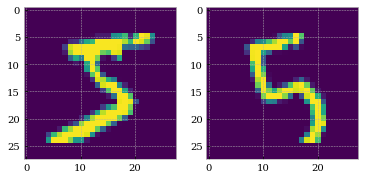

In [166]:
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(seller6_data[0])
ax[1].imshow(seller6_data[500])

In [167]:
n = seller1_data.shape[0]
dup1_data = seller1_data[:int(n // 2)].repeat(2, 1, 1) # 50% original
dup2_data = seller1_data[:int(n // 4)].repeat(4, 1, 1) # 25% original
dup3_data = seller1_data[:int(n // 10)].repeat(10, 1, 1) # 10% original
dup4_data = seller1_data[:int(n // 20)].repeat(20, 1, 1) # 5% original
dup5_data = seller1_data[:int(n // 50)].repeat(50, 1, 1) # 2% original
dup1_data.shape, dup2_data.shape, dup3_data.shape, dup4_data.shape, dup5_data.shape

dup1_data_flat = dup1_data.reshape(-1, 28*28) 
dup2_data_flat = dup2_data.reshape(-1, 28*28) 
dup3_data_flat = dup3_data.reshape(-1, 28*28) 
dup4_data_flat = dup4_data.reshape(-1, 28*28) 
dup5_data_flat = dup5_data.reshape(-1, 28*28) 

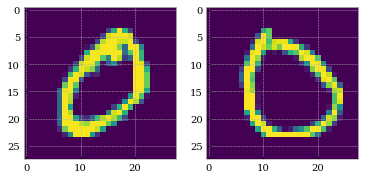

In [168]:
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(dup1_data[0])
ax[1].imshow(dup1_data[500])

In [169]:
mix1_data = torch.cat([seller1_data[:int(seller_samples * 0.9)], seller_fashion_data[:int(seller_samples * 0.1)]])
mix2_data = torch.cat([seller1_data[:int(seller_samples * 0.8)], seller_fashion_data[:int(seller_samples * 0.2)]])
mix3_data = torch.cat([seller1_data[:int(seller_samples * 0.7)], seller_fashion_data[:int(seller_samples * 0.3)]])
mix4_data = torch.cat([seller1_data[:int(seller_samples * 0.6)], seller_fashion_data[:int(seller_samples * 0.4)]])
mix5_data = torch.cat([seller1_data[:int(seller_samples * 0.5)], seller_fashion_data[:int(seller_samples * 0.5)]])
mix6_data = torch.cat([seller1_data[:int(seller_samples * 0.4)], seller_fashion_data[:int(seller_samples * 0.6)]])
mix7_data = torch.cat([seller1_data[:int(seller_samples * 0.3)], seller_fashion_data[:int(seller_samples * 0.7)]])
mix8_data = torch.cat([seller1_data[:int(seller_samples * 0.2)], seller_fashion_data[:int(seller_samples * 0.8)]])
mix9_data = torch.cat([seller1_data[:int(seller_samples * 0.1)], seller_fashion_data[:int(seller_samples * 0.9)]])

mix1_data_flat = mix1_data.reshape(-1, 28*28) 
mix2_data_flat = mix2_data.reshape(-1, 28*28) 
mix3_data_flat = mix3_data.reshape(-1, 28*28) 
mix4_data_flat = mix4_data.reshape(-1, 28*28) 
mix5_data_flat = mix5_data.reshape(-1, 28*28) 
mix6_data_flat = mix6_data.reshape(-1, 28*28) 
mix7_data_flat = mix7_data.reshape(-1, 28*28) 
mix8_data_flat = mix8_data.reshape(-1, 28*28) 
mix9_data_flat = mix9_data.reshape(-1, 28*28) 

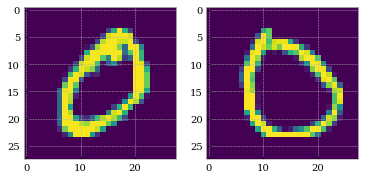

In [170]:
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(mix5_data[0])
ax[1].imshow(mix5_data[500])

In [171]:
upsample = lambda x: torch.nn.Upsample(scale_factor=2)(x)

In [172]:
batch_size = 64
buyer_loader = torch.utils.data.DataLoader(upsample(buyer_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
seller1_loader = torch.utils.data.DataLoader(upsample(seller1_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
seller2_loader = torch.utils.data.DataLoader(upsample(seller2_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
seller3_loader = torch.utils.data.DataLoader(upsample(seller3_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
seller4_loader = torch.utils.data.DataLoader(upsample(seller4_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
seller5_loader = torch.utils.data.DataLoader(upsample(seller5_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
seller6_loader = torch.utils.data.DataLoader(upsample(seller6_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
seller7_loader = torch.utils.data.DataLoader(upsample(seller7_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
seller8_loader = torch.utils.data.DataLoader(upsample(seller8_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
seller9_loader = torch.utils.data.DataLoader(upsample(seller9_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
seller10_loader = torch.utils.data.DataLoader(upsample(seller10_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
seller11_loader = torch.utils.data.DataLoader(upsample(seller11_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
seller12_loader = torch.utils.data.DataLoader(upsample(seller12_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
seller13_loader = torch.utils.data.DataLoader(upsample(seller13_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)

seller_fashion_loader = torch.utils.data.DataLoader(upsample(seller_fashion_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
seller_emnist_loader = torch.utils.data.DataLoader(upsample(seller_emnist_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
seller_cifar_loader = torch.utils.data.DataLoader(upsample(seller_cifar_data.moveaxis(-1, 1)), batch_size=batch_size)

In [173]:
dup1_loader = torch.utils.data.DataLoader(upsample(dup1_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
dup2_loader = torch.utils.data.DataLoader(upsample(dup2_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
dup3_loader = torch.utils.data.DataLoader(upsample(dup3_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
dup4_loader = torch.utils.data.DataLoader(upsample(dup4_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
dup5_loader = torch.utils.data.DataLoader(upsample(dup5_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)

mix1_loader = torch.utils.data.DataLoader(upsample(mix1_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
mix2_loader = torch.utils.data.DataLoader(upsample(mix2_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
mix3_loader = torch.utils.data.DataLoader(upsample(mix3_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
mix4_loader = torch.utils.data.DataLoader(upsample(mix4_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
mix5_loader = torch.utils.data.DataLoader(upsample(mix5_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
mix6_loader = torch.utils.data.DataLoader(upsample(mix6_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
mix7_loader = torch.utils.data.DataLoader(upsample(mix7_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
mix8_loader = torch.utils.data.DataLoader(upsample(mix8_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
mix9_loader = torch.utils.data.DataLoader(upsample(mix9_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)

In [174]:
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1).cuda()
model.eval();

In [23]:
buyer_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(buyer_loader)])
seller1_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(seller1_loader)])
seller2_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(seller2_loader)])
seller3_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(seller3_loader)])
seller4_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(seller4_loader)])
seller5_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(seller5_loader)])
seller6_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(seller6_loader)])
seller7_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(seller7_loader)])
seller8_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(seller8_loader)])
seller9_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(seller9_loader)])
seller10_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(seller10_loader)])
seller11_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(seller11_loader)])
seller12_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(seller12_loader)])
seller13_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(seller13_loader)])

seller_fashion_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(seller_fashion_loader)])
seller_emnist_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(seller_emnist_loader)])
seller_cifar_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(seller_cifar_loader)])

In [24]:
dup1_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(dup1_loader)])
dup2_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(dup2_loader)])
dup3_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(dup3_loader)])
dup4_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(dup4_loader)])
dup5_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(dup5_loader)])

mix1_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(mix1_loader)])
mix2_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(mix2_loader)])
mix3_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(mix3_loader)])
mix4_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(mix4_loader)])
mix5_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(mix5_loader)])
mix6_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(mix6_loader)])
mix7_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(mix7_loader)])
mix8_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(mix8_loader)])
mix9_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(mix9_loader)])

In [25]:
torch.cuda.empty_cache()

In [175]:
# for t in (1e-3, 1e-2, 1e-1, 1e-0, 1e1, 1e2, 1e3):
#     print(str(t).ljust(10), (buyer_eig_val > t).sum())

In [176]:
# n_components = 50
# n_components = 20
# n_components = 15
# n_components = 10
n_components = 2
whiten       = True
# use_features = False 
use_features = False

In [177]:
X_b = buyer_features.float() if use_features else buyer_data_flat.float()
X_b -= X_b.mean(0)
buyer_cov = np.cov(X_b.T)

buyer_eig_val, buyer_eig_vec = np.linalg.eig(buyer_cov)
buyer_eig_val = buyer_eig_val.real
buyer_eig_vec = buyer_eig_vec.real
print(buyer_eig_val[:n_components])
print(X_b @ buyer_eig_vec[:, :n_components])

[7.87628432 4.483929  ]
tensor([[ 0.4593, -3.0747],
        [ 3.7892, -0.2599],
        [-4.9834, -0.8178],
        ...,
        [-0.8157, -1.4850],
        [-1.5937, -4.4640],
        [ 0.8719,  2.8992]], dtype=torch.float64)


In [178]:
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=whiten)
pca.fit(X_b)
# pca.fit(buyer_data_flat.float().T)

# buyer_values = pca.singular_values_
buyer_values = pca.explained_variance_
# buyer_components = np.abs(pca.components_)
buyer_components = pca.components_
print(buyer_values[:n_components])
pca.fit_transform(X_b)

[7.87628432 4.483929  ]


array([[-0.16366625, -1.45204663],
       [-1.35015011, -0.1227512 ],
       [ 1.77569685, -0.38621981],
       ...,
       [ 0.29063483, -0.70127766],
       [ 0.56787048, -2.10811631],
       [-0.31067515,  1.36912737]])

In [179]:
# X_b @ torch.tensor(buyer_components[:n_components]).float().T

In [180]:
pca.explained_variance_

array([7.87628432, 4.483929  ])

In [181]:
X_1 = seller1_features if use_features else seller1_data_flat.float()
X_1 -= X_1.mean(0)
seller1_cov = np.cov(X_1.T)

X_2 = seller2_features if use_features else seller2_data_flat.float()
X_2 -= X_2.mean(0)
seller2_cov = np.cov(X_2.T)

X_3 = seller3_features if use_features else seller3_data_flat.float()
X_3 -= X_3.mean(0)
seller3_cov = np.cov(X_3.T)
# seller3_cov *= 1 / X_3.shape[0]

X_4 = seller4_features if use_features else seller4_data_flat.float()
X_4 -= X_4.mean(0)
seller4_cov = np.cov(X_4.T)
# seller4_cov *= 1 / X_4.shape[0]

X_5 = seller5_features if use_features else seller5_data_flat.float()
X_5 -= X_5.mean(0)
seller5_cov = np.cov(X_5.T)

X_6 = seller6_features if use_features else seller6_data_flat.float()
X_6 -= X_6.mean(0)
seller6_cov = np.cov(X_6.T)

X_7 = seller7_features if use_features else seller7_data_flat.float()
X_7 -= X_7.mean(0)
seller7_cov = np.cov(X_7.T)

X_8 = seller8_features if use_features else seller8_data_flat.float()
X_8 -= X_8.mean(0)
seller8_cov = np.cov(X_8.T)

X_9 = seller9_features if use_features else seller9_data_flat.float()
X_9 -= X_9.mean(0)
seller9_cov = np.cov(X_9.T)

X_10 = seller10_features if use_features else seller10_data_flat.float()
X_10 -= X_10.mean(0)
seller10_cov = np.cov(X_10.T)

X_11 = seller11_features if use_features else seller11_data_flat.float()
X_11 -= X_11.mean(0)
seller11_cov = np.cov(X_11.T)

X_12 = seller12_features if use_features else seller12_data_flat.float()
X_12 -= X_12.mean(0)
seller12_cov = np.cov(X_12.T)

X_13 = seller13_features if use_features else seller13_data_flat.float()
X_13 -= X_13.mean(0)
seller13_cov = np.cov(X_13.T)

X_fashion = seller_fashion_features if use_features else seller_fashion_data_flat.float()
X_fashion -= X_fashion.mean(0)
seller_fashion_cov = np.cov(X_fashion.T)

X_cifar = seller_cifar_features if use_features else seller_cifar_data_flat.float()
X_cifar -= X_cifar.mean(0)
seller_cifar_cov = np.cov(X_cifar.T)

X_emnist = seller_emnist_features if use_features else seller_emnist_data_flat.float()
X_emnist -= X_emnist.mean(0)
seller_emnist_cov = np.cov(X_emnist.T)


In [182]:
X_dup1 = dup1_features if use_features else dup1_data_flat.float()
X_dup1 -= X_dup1.mean(0)
dup1_cov = np.cov(X_dup1.T)

X_dup2 = dup2_features if use_features else dup2_data_flat.float()
X_dup2 -= X_dup2.mean(0)
dup2_cov = np.cov(X_dup2.T)

X_dup3 = dup3_features if use_features else dup3_data_flat.float()
X_dup3 -= X_dup3.mean(0)
dup3_cov = np.cov(X_dup3.T)

X_dup4 = dup4_features if use_features else dup4_data_flat.float()
X_dup4 -= X_dup4.mean(0)
dup4_cov = np.cov(X_dup4.T)

X_dup5 = dup5_features if use_features else dup5_data_flat.float()
X_dup5 -= X_dup5.mean(0)
dup5_cov = np.cov(X_dup5.T)

X_mix1 = mix1_features if use_features else mix1_data_flat.float()
X_mix1 -= X_mix1.mean(0)
mix1_cov = np.cov(X_mix1.T)

X_mix2 = mix2_features if use_features else mix2_data_flat.float()
X_mix2 -= X_mix2.mean(0)
mix2_cov = np.cov(X_mix2.T)

X_mix3 = mix3_features if use_features else mix3_data_flat.float()
X_mix3 -= X_mix3.mean(0)
mix3_cov = np.cov(X_mix3.T)

X_mix4 = mix4_features if use_features else mix4_data_flat.float()
X_mix4 -= X_mix4.mean(0)
mix4_cov = np.cov(X_mix4.T)

X_mix5 = mix5_features if use_features else mix5_data_flat.float()
X_mix5 -= X_mix5.mean(0)
mix5_cov = np.cov(X_mix5.T)

X_mix6 = mix6_features if use_features else mix6_data_flat.float()
X_mix6 -= X_mix6.mean(0)
mix6_cov = np.cov(X_mix6.T)

X_mix7 = mix7_features if use_features else mix7_data_flat.float()
X_mix7 -= X_mix7.mean(0)
mix7_cov = np.cov(X_mix7.T)

X_mix8 = mix8_features if use_features else mix8_data_flat.float()
X_mix8 -= X_mix8.mean(0)
mix8_cov = np.cov(X_mix8.T)

X_mix9 = mix9_features if use_features else mix9_data_flat.float()
X_mix9 -= X_mix9.mean(0)
mix9_cov = np.cov(X_mix9.T)

In [183]:

def compute_volumes(datasets, d=1):
    # d = datasets[0].shape[1]
    # for i in range(len(datasets)):
        # datasets[i] = datasets[i].reshape(-1 ,d)

    # X = np.concatenate(datasets, axis=0).reshape(-1, d)
    volumes = np.zeros(len(datasets))
    for i, dataset in enumerate(datasets):
        volumes[i] = np.sqrt(np.linalg.det( dataset.T @ dataset ) + 1e-8)

    # volume_all = np.sqrt(np.linalg.det(X.T @ X) + 1e-8).round(3)
    return volumes#, volume_all


def compute_X_tilde_and_counts(X, omega=0.1):
    """
    Compresses the original feature matrix X to  X_tilde with the specified omega.

    Returns:
       X_tilde: compressed np.ndarray
       cubes: a dictionary of cubes with the respective counts in each dcube
    """
    X = torch.tensor(X)
    
    D = X.shape[1]

    # assert 0 < omega <= 1, "omega must be within range [0,1]."

    m = math.ceil(1.0 / omega) # number of intervals for each dimension

    cubes = collections.Counter() # a dictionary to store the freqs
    # key: (1,1,..)  a d-dimensional tuple, each entry between [0, m-1]
    # value: counts

    Omega = collections.defaultdict(list)
    # Omega = {}
    
    min_ds = torch.min(X, axis=0).values

    # a dictionary to store cubes of not full size
    for x in X:
        cube = []
        for d, xd in enumerate(x - min_ds):
            d_index = math.floor(xd / omega)
            cube.append(d_index)

        cube_key = tuple(cube)
        cubes[cube_key] += 1

        Omega[cube_key].append(x)

        '''
        if cube_key in Omega:
            
            # Implementing mean() to compute the average of all rows which fall in the cube
            
            Omega[cube_key] = Omega[cube_key] * (1 - 1.0 / cubes[cube_key]) + 1.0 / cubes[cube_key] * x
            # Omega[cube_key].append(x)
        else:
             Omega[cube_key] = x
        '''
    X_tilde = torch.stack([torch.stack(list(value)).mean(axis=0) for key, value in Omega.items()])

    # X_tilde = stack(list(Omega.values()))

    return X_tilde, cubes



def compute_robust_volumes(X_tildes, dcube_collections):
        
    N = sum([len(X_tilde) for X_tilde in X_tildes])
    alpha = 1.0 / (10 * N) # it means we set beta = 10
    # print("alpha is :{}, and (1 + alpha) is :{}".format(alpha, 1 + alpha))

    # volumes, volume_all = compute_volumes(X_tildes, d=X_tildes[0].shape[1])
    volumes = compute_volumes(X_tildes, d=X_tildes[0].shape[1])
    robust_volumes = np.zeros_like(volumes)
    for i, (volume, hypercubes) in enumerate(zip(volumes, dcube_collections)):
        rho_omega_prod = 1.0
        for cube_index, freq_count in hypercubes.items():
            
            # if freq_count == 1: continue # volume does not monotonically increase with omega
            # commenting this if will result in volume monotonically increasing with omega
            rho_omega = (1 - alpha**(freq_count + 1)) / (1 - alpha)

            rho_omega_prod *= rho_omega

        robust_volumes[i] = (volume * rho_omega_prod).round(3)
    return robust_volumes

def get_volume(cov, omega=0.2, epsilon=np.finfo(np.float32).eps):
    
    X_tilde, cubes = compute_X_tilde_and_counts(cov, omega=omega)
    vol = compute_robust_volumes([X_tilde], [cubes])
    return max(vol[0], epsilon)

In [184]:
# np.linalg.cond(buyer_components @ seller1_cov.T)

In [185]:
buyer_eig_val.mean(), np.median(buyer_eig_val)

(0.06849837312517935, 0.002525603771612477)

In [186]:
# for n_components in (2, 5, 10, 15, 20, 30):
# for n_components in (4, 6, 8, 10, 2):
n_components = 2
# n_components = 3
# n_components = 4
# n_components = 5
# n_components = 8
# n_components = 10
print(str(n_components).center(20, '-'))
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=whiten)
pca.fit(X_b)

buyer_proj_cov = pca.transform(buyer_cov)
seller1_proj_cov = pca.transform(seller1_cov)
seller2_proj_cov = pca.transform(seller2_cov)
seller3_proj_cov = pca.transform(seller3_cov)
seller4_proj_cov = pca.transform(seller4_cov)
seller5_proj_cov = pca.transform(seller5_cov)
seller6_proj_cov = pca.transform(seller6_cov)
seller7_proj_cov = pca.transform(seller7_cov)
seller8_proj_cov = pca.transform(seller8_cov)
seller9_proj_cov = pca.transform(seller9_cov)
seller10_proj_cov = pca.transform(seller10_cov)
seller11_proj_cov = pca.transform(seller11_cov)
seller12_proj_cov = pca.transform(seller12_cov)
seller13_proj_cov = pca.transform(seller13_cov)

seller_fashion_proj_cov = pca.transform(seller_fashion_cov)
seller_emnist_proj_cov = pca.transform(seller_emnist_cov)
if use_features:
    seller_cifar_proj_cov = pca.transform(seller_cifar_cov)

omega = 0.1
# omega = 0.5

buyer_vol = get_volume(buyer_proj_cov, omega=omega)
seller1_vol = get_volume(seller1_proj_cov, omega=omega)
seller2_vol = get_volume(seller2_proj_cov, omega=omega)
seller3_vol = get_volume(seller3_proj_cov, omega=omega)
seller4_vol = get_volume(seller4_proj_cov, omega=omega)
seller5_vol = get_volume(seller5_proj_cov, omega=omega)
seller6_vol = get_volume(seller6_proj_cov, omega=omega)
seller7_vol = get_volume(seller7_proj_cov, omega=omega)
seller8_vol = get_volume(seller8_proj_cov, omega=omega)
seller9_vol = get_volume(seller9_proj_cov, omega=omega)
seller10_vol = get_volume(seller10_proj_cov, omega=omega)
seller11_vol = get_volume(seller11_proj_cov, omega=omega)
seller12_vol = get_volume(seller12_proj_cov, omega=omega)
seller13_vol = get_volume(seller13_proj_cov, omega=omega)

seller_fashion_vol = get_volume(seller_fashion_proj_cov, omega=omega)
seller_emnist_vol = get_volume(seller_emnist_proj_cov, omega=omega)
if use_features:
    seller_cifar_vol = get_volume(seller_cifar_proj_cov, omega=omega)

print(f'{buyer_vol:e}')
print(f'{seller1_vol:e}')
print(f'{seller2_vol:e}')
print(f'{seller3_vol:e}')
print(f'{seller4_vol:e}')
print(f'{seller5_vol:e}')
print(f'{seller6_vol:e}')
print(f'{seller7_vol:e}')
print(f'{seller8_vol:e}')
print(f'{seller9_vol:e}')
print(f'{seller_fashion_vol:e}')
print(f'{seller_emnist_vol:e}')
if use_features:
    print(f'{seller_cifar_vol:e}')

---------2----------
7.330000e-01
6.770000e-01
3.080000e-01
9.900000e-02
7.600000e-02
4.200000e-02
2.300000e-02
4.700000e-02
3.000000e-02
1.010000e-01
9.500000e-02
8.600000e-02


In [187]:
dup1_proj_cov = pca.transform(dup1_cov)
dup1_vol = get_volume(dup1_proj_cov, omega=omega)

dup2_proj_cov = pca.transform(dup2_cov)
dup2_vol = get_volume(dup2_proj_cov, omega=omega)

dup3_proj_cov = pca.transform(dup3_cov)
dup3_vol = get_volume(dup3_proj_cov, omega=omega)

dup4_proj_cov = pca.transform(dup4_cov)
dup4_vol = get_volume(dup4_proj_cov, omega=omega)

dup5_proj_cov = pca.transform(dup5_cov)
dup5_vol = get_volume(dup5_proj_cov, omega=omega)

mix1_proj_cov = pca.transform(mix1_cov)
mix1_vol = get_volume(mix1_proj_cov, omega=omega)

mix2_proj_cov = pca.transform(mix2_cov)
mix2_vol = get_volume(mix2_proj_cov, omega=omega)

mix3_proj_cov = pca.transform(mix3_cov)
mix3_vol = get_volume(mix3_proj_cov, omega=omega)

mix4_proj_cov = pca.transform(mix4_cov)
mix4_vol = get_volume(mix4_proj_cov, omega=omega)

mix5_proj_cov = pca.transform(mix5_cov)
mix5_vol = get_volume(mix5_proj_cov, omega=omega)

mix6_proj_cov = pca.transform(mix6_cov)
mix6_vol = get_volume(mix6_proj_cov, omega=omega)

mix7_proj_cov = pca.transform(mix7_cov)
mix7_vol = get_volume(mix7_proj_cov, omega=omega)

mix8_proj_cov = pca.transform(mix8_cov)
mix8_vol = get_volume(mix8_proj_cov, omega=omega)

mix9_proj_cov = pca.transform(mix9_cov)
mix9_vol = get_volume(mix9_proj_cov, omega=omega)


In [188]:
def div_rel_func(buyer_eig_vals, buyer_eig_vecs, seller_cov, threshold=1e-2, num_components=2):
    buyer_vals = buyer_eig_vals[:num_components]
    # buyer_vecs = np.abs(buyer_eig_vecs[:num_components])
    buyer_vecs = buyer_eig_vecs[:num_components]
    seller_vals = np.linalg.norm(seller_cov @ buyer_vecs.T, axis=0)

    # Diversity
    div_components = np.abs(buyer_vals - seller_vals) / np.maximum(buyer_vals, seller_vals)

    #  Relevance
    rel_components = np.minimum(buyer_vals, seller_vals) / np.maximum(buyer_vals, seller_vals)
    # print('div', div_components)
    # print('rel', rel_components)

    # filter buyer components by threshold 
    keep_mask = buyer_vals >= threshold

    div = np.prod(np.where(keep_mask, div_components, 1)) ** (1 / keep_mask.sum())
    rel = np.prod(np.where(keep_mask, rel_components, 1)) ** (1 / keep_mask.sum())
    return rel, div #, keep_mask.sum()

In [189]:
def div_rel_func2(buyer_eig_val, buyer_eig_vec, seller_covariance, num_components=None, threshold=1e-1):
    seller_eig_val = np.zeros([len(seller_covariance)])
    Diversity = 1
    Relevance = 1
    count_root = 0
    # div  = []
    # rel = []
    
    # buyer_eig_vec = np.abs(buyer_eig_vec)
    
    for i in range(len(seller_covariance)):
        if num_components is not None and i >= num_components:
            break
        elif buyer_eig_val[i] < threshold:
            continue
            
        count_root += 1
        vec_seller_covariance = np.matmul(seller_covariance, buyer_eig_vec[:, i])
        seller_eig_val[i] = np.abs(np.linalg.norm(vec_seller_covariance))
        # print((seller_eig_val[i], buyer_eig_val[i]))
        Diversity *= np.abs(seller_eig_val[i] - buyer_eig_val[i]) / max(seller_eig_val[i], buyer_eig_val[i])
        Relevance *= min(seller_eig_val[i], buyer_eig_val[i]) / max(seller_eig_val[i], buyer_eig_val[i]) 
        # div.append(np.abs(seller_eig_val[i] - buyer_eig_val[i]) / max(seller_eig_val[i], buyer_eig_val[i]))
        # rel.append(min(seller_eig_val[i], buyer_eig_val[i]) / max(seller_eig_val[i], buyer_eig_val[i]) )

    # print(div)
    # print(rel)
    return (Relevance)**(1/count_root), (Diversity)**(1/count_root), count_root

In [190]:

# for num_components in (2, 5, 10, 15, 20):
#     # print(str(num_components).center(40, '-'))
#     # print(div_rel_func2(buyer_eig_val, buyer_eig_vec, seller1_cov, threshold=threshold, num_components=num_components))
#     # print(div_rel_func2(buyer_eig_val, buyer_eig_vec, seller2_cov, threshold=threshold, num_components=num_components))
#     # print(div_rel_func2(buyer_eig_val, buyer_eig_vec, seller3_cov, threshold=threshold, num_components=num_components))
#     # print(div_rel_func2(buyer_eig_val, buyer_eig_vec, seller4_cov, threshold=threshold, num_components=num_components))
#     # print(div_rel_func2(buyer_eig_val, buyer_eig_vec, seller5_cov, threshold=threshold, num_components=num_components))
    
#     print(str(num_components).center(40, '-'))
#     print(div_rel_func(buyer_values, buyer_components, seller1_cov, threshold=threshold, num_components=num_components))
#     print(div_rel_func(buyer_values, buyer_components, seller2_cov, threshold=threshold, num_components=num_components))
#     print(div_rel_func(buyer_values, buyer_components, seller3_cov, threshold=threshold, num_components=num_components))
#     print(div_rel_func(buyer_values, buyer_components, seller4_cov, threshold=threshold, num_components=num_components))
#     print(div_rel_func(buyer_values, buyer_components, seller5_cov, threshold=threshold, num_components=num_components))
#     print(div_rel_func(buyer_values, buyer_components, seller6_cov, threshold=threshold, num_components=num_components))
#     print(div_rel_func(buyer_values, buyer_components, seller7_cov, threshold=threshold, num_components=num_components))
#     print(div_rel_func(buyer_values, buyer_components, seller8_cov, threshold=threshold, num_components=num_components))
#     print(div_rel_func(buyer_values, buyer_components, seller9_cov, threshold=threshold, num_components=num_components))
#     print(div_rel_func(buyer_values, buyer_components, seller_fashion_cov, threshold=threshold, num_components=num_components))
#     print(div_rel_func(buyer_values, buyer_components, seller_emnist_cov, threshold=threshold, num_components=num_components))
#     if use_features:
#         print(div_rel_func(buyer_values, buyer_components, seller_cifar_cov, threshold=threshold, num_components=num_components))

In [191]:
threshold = 0.1
num_components = 2
# num_components = 3
# num_components = 4
# num_components = 10
kwargs = {'threshold': threshold, 'num_components': num_components}

In [192]:
import matplotlib

In [193]:
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
# rcParams['font.sans-serif'] = ['Tahoma']

In [194]:
figures = Path('figures')

/tmp/ipykernel_1987/3948846152.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([f'{x:.1f}' for x in ax[0].get_xticks()], fontsize=fontsize-8)
/tmp/ipykernel_1987/3948846152.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels([f'{y:.1f}' for y in ax[0].get_yticks()], fontsize=fontsize-8)
/tmp/ipykernel_1987/3948846152.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels([f'{x:.1f}' for x in ax[1].get_xticks()], fontsize=fontsize-8)
/tmp/ipykernel_1987/3948846152.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels([y for y in ax[1].get_yticks()], fontsize=fontsize-8)


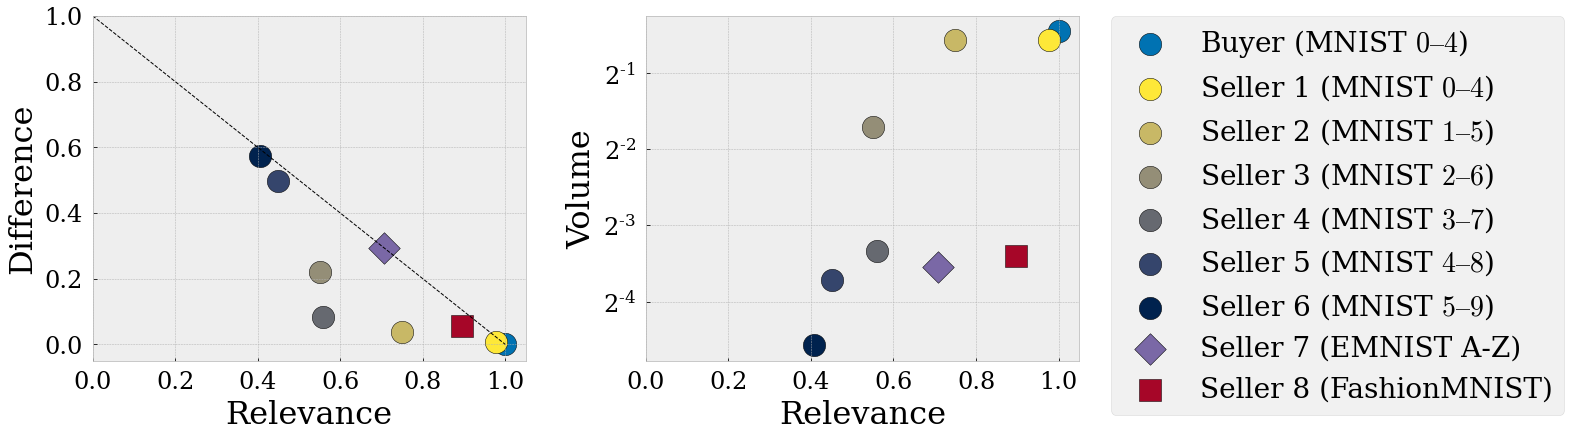

In [195]:
cividis = [np.array([matplotlib.colormaps['cividis'].colors[int(k)]]) for k in np.linspace(255, 0, 6)]

fontsize = 32
s = 500

fig, ax = plt.subplots(figsize=(16, 7), ncols=2)

ax[0].scatter(*div_rel_func(buyer_values, buyer_components, buyer_cov, **kwargs),   c='#0072B2', edgecolor='k', s=s, label=r'Buyer MNIST $0–4$')

ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller1_cov, **kwargs), c=cividis[0], edgecolor='k', s=s, label=r'Seller mnist $0–4$')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller2_cov, **kwargs), c=cividis[1], edgecolor='k', s=s, label=r'Seller mnist $1–5$')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller3_cov, **kwargs), c=cividis[2], edgecolor='k', s=s, label=r'Seller mnist $2–6$')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller4_cov, **kwargs), c=cividis[3], edgecolor='k', s=s, label=r'Seller mnist $3–7$')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller5_cov, **kwargs), c=cividis[4], edgecolor='k', s=s, label=r'Seller mnist $4–8$')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller6_cov, **kwargs), c=cividis[5], edgecolor='k', s=s, label=r'Seller mnist $5–9$')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller_emnist_cov, **kwargs), c='C2', edgecolor='k', s=s, marker='D', label=r'Seller emnist')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller_fashion_cov, **kwargs), c='C1', edgecolor='k', s=s, marker='s', label=r'Seller fashion')
if use_features:
    ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller_cifar_cov, **kwargs), edgecolor='k', s=s, marker='^', label=r'Seller Cifar')

ax[0].set_xlim(0, 1.05)
ax[0].set_ylim(-0.05, 1)
ax[0].plot(np.arange(0, 1.1, 0.1), 1 - np.arange(0, 1.1, 0.1), marker='', markersize = 4, markeredgewidth=1.5, color='black', linestyle='--', linewidth=1)
ax[0].set_xlabel('Relevance', fontsize=fontsize, labelpad=6)
ax[0].set_ylabel('Difference', fontsize=fontsize, labelpad=6)
ax[0].set_xticklabels([f'{x:.1f}' for x in ax[0].get_xticks()], fontsize=fontsize-8)
ax[0].set_yticklabels([f'{y:.1f}' for y in ax[0].get_yticks()], fontsize=fontsize-8)
ax[0].tick_params(axis='both', which='major', pad=10)

ax[1].scatter(div_rel_func(buyer_values, buyer_components, buyer_cov, **kwargs)[0],   buyer_vol,   c='#0072B2', edgecolor='k', s=s, label=r'Buyer (MNIST $0–4$)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller1_cov, **kwargs)[0], seller1_vol, c=cividis[0], edgecolor='k', s=s, label=r'Seller 1 (MNIST $0–4$)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller2_cov, **kwargs)[0], seller1_vol, c=cividis[1], edgecolor='k', s=s, label=r'Seller 2 (MNIST $1–5$)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller3_cov, **kwargs)[0], seller2_vol, c=cividis[2], edgecolor='k', s=s, label=r'Seller 3 (MNIST $2–6$)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller4_cov, **kwargs)[0], seller3_vol, c=cividis[3], edgecolor='k', s=s, label=r'Seller 4 (MNIST $3–7$)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller5_cov, **kwargs)[0], seller4_vol, c=cividis[4], edgecolor='k', s=s, label=r'Seller 5 (MNIST $4–8$)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller6_cov, **kwargs)[0], seller5_vol, c=cividis[5], edgecolor='k', s=s, label=r'Seller 6 (MNIST $5–9$)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller_emnist_cov, **kwargs)[0], seller_emnist_vol, c='C2', edgecolor='k', s=s, marker='D', label=r'Seller 7 (EMNIST A-Z)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller_fashion_cov, **kwargs)[0], seller_fashion_vol, c='C1', edgecolor='k', s=s, marker='s', label=r'Seller 8 (FashionMNIST)')
if use_features:
    ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller_cifar_cov, **kwargs)[0], seller_cifar_vol, edgecolor='k', s=s, marker='^', label=r'Seller cifar')

ax[1].set_xlim(0, 1.05)
# ax[1].set_ylim(-0.05, ax[1].get_ylim()[1])
# ax[0].set_ylim(-0.05, 1.05)
ax[1].set_xlabel('Relevance', fontsize=32, labelpad=6)
ax[1].set_ylabel('Volume', fontsize=32, labelpad=6)
ax[1].set_xticklabels([f'{x:.1f}' for x in ax[1].get_xticks()], fontsize=fontsize-8)
ax[1].set_yticklabels([y for y in ax[1].get_yticks()], fontsize=fontsize-8)
ax[1].set_yscale('log',base=2) 
ax[1].tick_params(axis='both', which='major', pad=10)

plt.tight_layout(pad=4)
plt.legend(prop={'size': fontsize-4}, bbox_to_anchor=(1.04, 1.04))
plt.savefig(figures / f'mnist-overlap.pdf', bbox_inches='tight')
plt.show()

In [196]:
use_features

False

/tmp/ipykernel_1987/3274540227.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([f'{x:.1f}' for x in ax[0].get_xticks()], fontsize=fontsize-8)
/tmp/ipykernel_1987/3274540227.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels([f'{y:.1f}' for y in ax[0].get_yticks()], fontsize=fontsize-8)
/tmp/ipykernel_1987/3274540227.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels([f'{x:.1f}' for x in ax[1].get_xticks()], fontsize=fontsize-8)
/tmp/ipykernel_1987/3274540227.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels([y for y in ax[1].get_yticks()], fontsize=fontsize-8)


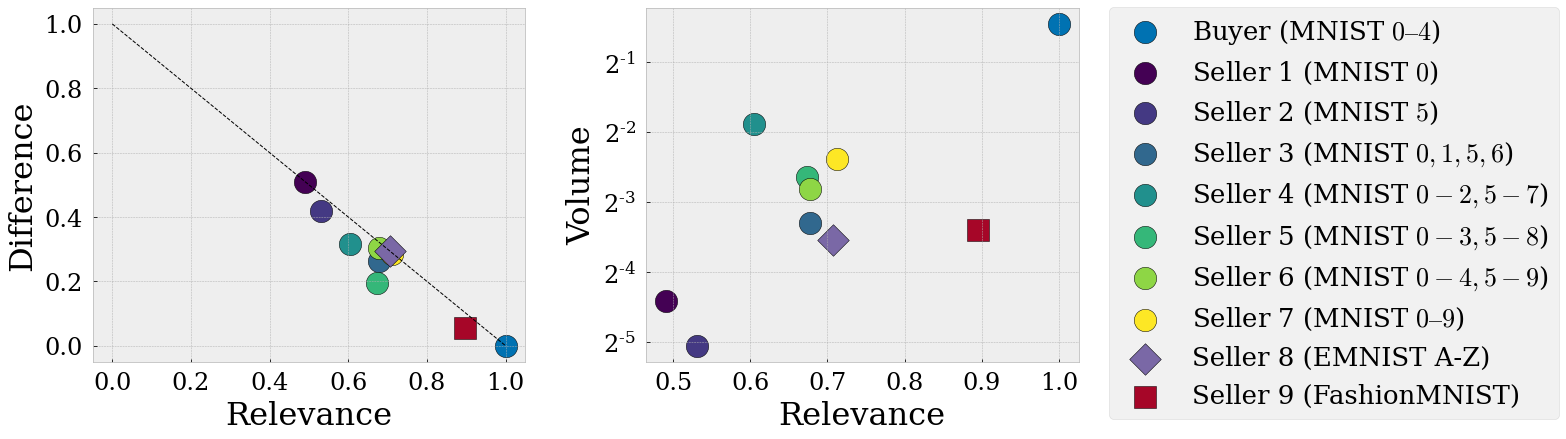

In [207]:
viridis = [np.array([matplotlib.colormaps['viridis'].colors[int(k)]]) for k in np.linspace(0, 255, 7)]

fontsize = 32
s = 500

fig, ax = plt.subplots(figsize=(16, 7), ncols=2)

ax[0].scatter(*div_rel_func(buyer_values, buyer_components, buyer_cov, **kwargs),   c='#0072B2', edgecolor='k', s=s, label=r'Buyer MNIST $0–4$')

ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller7_cov, **kwargs), c=viridis[0], edgecolor='k', s=s)
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller8_cov, **kwargs), c=viridis[1], edgecolor='k', s=s)
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller9_cov, **kwargs), c=viridis[2], edgecolor='k', s=s)
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller10_cov, **kwargs), c=viridis[3], edgecolor='k', s=s)
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller11_cov, **kwargs), c=viridis[4], edgecolor='k', s=s)
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller12_cov, **kwargs), c=viridis[5], edgecolor='k', s=s)
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller13_cov, **kwargs), c=viridis[6], edgecolor='k', s=s)
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller_emnist_cov, **kwargs), c='C2', edgecolor='k', s=s, marker='D')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller_fashion_cov, **kwargs), c='C1', edgecolor='k', s=s, marker='s')
if use_features:
    ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller_cifar_cov, **kwargs), edgecolor='k', s=s, marker='^')

# ax[0].set_xlim(0.5, 1.05)
# ax[0].set_ylim(-0.02, 0.5)
ax[0].plot(np.arange(0, 1.1, 0.1), 1 - np.arange(0, 1.1, 0.1), marker='', markersize = 4, markeredgewidth=1.5, color='black', linestyle='--', linewidth=1)
ax[0].set_xlabel('Relevance', fontsize=fontsize, labelpad=6)
ax[0].set_ylabel('Difference', fontsize=fontsize, labelpad=6)
ax[0].set_xticklabels([f'{x:.1f}' for x in ax[0].get_xticks()], fontsize=fontsize-8)
ax[0].set_yticklabels([f'{y:.1f}' for y in ax[0].get_yticks()], fontsize=fontsize-8)
ax[0].tick_params(axis='both', which='major', pad=10)

ax[1].scatter(div_rel_func(buyer_values, buyer_components, buyer_cov, **kwargs)[0],   buyer_vol,   c='#0072B2', edgecolor='k', s=s, label=r'Buyer (MNIST $0–4$)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller7_cov, **kwargs)[0], seller7_vol, c=viridis[0], edgecolor='k', s=s, label=r'Seller 1 (MNIST $0$)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller8_cov, **kwargs)[0], seller8_vol, c=viridis[1], edgecolor='k', s=s, label=r'Seller 2 (MNIST $5$)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller9_cov, **kwargs)[0], seller9_vol, c=viridis[2], edgecolor='k', s=s, label=r'Seller 3 (MNIST $0, 1, 5, 6$)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller10_cov, **kwargs)[0], seller10_vol, c=viridis[3], edgecolor='k', s=s, label=r'Seller 4 (MNIST $0-2, 5-7$)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller11_cov, **kwargs)[0], seller11_vol, c=viridis[4], edgecolor='k', s=s, label=r'Seller 5 (MNIST $0-3, 5-8$)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller12_cov, **kwargs)[0], seller12_vol, c=viridis[5], edgecolor='k', s=s, label=r'Seller 6 (MNIST $0-4, 5-9$)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller13_cov, **kwargs)[0], seller13_vol, c=viridis[6], edgecolor='k', s=s, label=r'Seller 7 (MNIST $0–9$)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller_emnist_cov, **kwargs)[0], seller_emnist_vol, c='C2', edgecolor='k', s=s, marker='D', label=r'Seller 8 (EMNIST A-Z)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller_fashion_cov, **kwargs)[0], seller_fashion_vol, c='C1', edgecolor='k', s=s, marker='s', label=r'Seller 9 (FashionMNIST)')
if use_features:
    ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller_cifar_cov, **kwargs)[0], seller_cifar_vol, edgecolor='k', s=s, marker='^', label=r'Seller cifar')

# ax[1].set_xlim(0.5, 1.05)
# ax[1].set_ylim(-0.05, ax[1].get_ylim()[1])
# ax[0].set_ylim(-0.05, 1.05)
ax[1].set_xlabel('Relevance', fontsize=32, labelpad=6)
ax[1].set_ylabel('Volume', fontsize=32, labelpad=6)
ax[1].set_xticklabels([f'{x:.1f}' for x in ax[1].get_xticks()], fontsize=fontsize-8)
ax[1].set_yticklabels([y for y in ax[1].get_yticks()], fontsize=fontsize-8)
ax[1].set_yscale('log',base=2) 
ax[1].tick_params(axis='both', which='major', pad=10)

plt.tight_layout(pad=4)
plt.legend(prop={'size': fontsize-6}, bbox_to_anchor=(1.04, 1.04))
plt.savefig(figures / f'mnist-complex.pdf', bbox_inches='tight')
plt.show()

In [198]:
# s = 500
# plt.figure(figsize=(8, 8))

# plt.scatter(*div_rel_func(buyer_values, buyer_components, buyer_cov, **kwargs),   edgecolor='k', s=s, label=r'Buyer mnist $0–4$')

# plt.scatter(*div_rel_func(buyer_values, buyer_components, seller6_cov, **kwargs), c=viridis[0], marker='P', edgecolor='k', s=s, label=r'Seller mnist $0$')
# plt.scatter(*div_rel_func(buyer_values, buyer_components, seller7_cov, **kwargs), c=viridis[0], marker='X', edgecolor='k', s=s, label=r'Seller mnist $5$')
# plt.scatter(*div_rel_func(buyer_values, buyer_components, seller8_cov, **kwargs), c=viridis[1], edgecolor='k', s=s, label=r'Seller mnist $0, 5$')
# plt.scatter(*div_rel_func(buyer_values, buyer_components, seller9_cov, **kwargs), c=viridis[2], edgecolor='k', s=s, label=r'Seller mnist $0, 1, 5, 6$')
# plt.scatter(*div_rel_func(buyer_values, buyer_components, seller10_cov, **kwargs), c=viridis[3], edgecolor='k', s=s, label=r'Seller mnist $0–2, 5-7$')
# plt.scatter(*div_rel_func(buyer_values, buyer_components, seller11_cov, **kwargs), c=viridis[4], edgecolor='k', s=s, label=r'Seller mnist $0-3, 5-8$')
# plt.scatter(*div_rel_func(buyer_values, buyer_components, seller12_cov, **kwargs), c=viridis[5], edgecolor='k', s=s, label=r'Seller mnist $0-9$')

# plt.scatter(*div_rel_func(buyer_values, buyer_components, seller_fashion_cov, **kwargs), edgecolor='k', s=s, marker='s', label=r'Seller fashion')
# plt.scatter(*div_rel_func(buyer_values, buyer_components, seller_emnist_cov, **kwargs), edgecolor='k', s=s, marker='d', label=r'Seller emnist')
# if use_features:
#     plt.scatter(*div_rel_func(buyer_values, buyer_components, seller_cifar_cov, **kwargs), edgecolor='k', s=s, marker='^', label=r'Seller Cifar')

# plt.xlim(0, 1.05)
# plt.ylim(0, 1.05)
# plt.plot(np.arange(0, 1.1, 0.1), 1 - np.arange(0, 1.1, 0.1), marker='', markersize = 4, markeredgewidth=1.5, color='black', linestyle='--', linewidth=1)
# plt.xlabel('Relevance', fontsize=32)
# plt.ylabel('Diversity', fontsize=32)
# plt.legend(prop={'size': 20}, bbox_to_anchor=(1.70, 1.00))
# plt.savefig(f'mnist-diversity-complex.png', bbox_inches='tight')
# plt.show()

In [199]:

# s = 500
# plt.figure(figsize=(8, 8))
# plt.scatter(div_rel_func(buyer_values, buyer_components, buyer_cov, **kwargs)[0],   buyer_vol,   edgecolor='k', s=s, label=r'Buyer mnist $0–4$')

# plt.scatter(div_rel_func(buyer_values, buyer_components, seller6_cov, **kwargs)[0], seller6_vol, c=viridis[0], marker='P', edgecolor='k', s=s, label=r'Seller mnist $0$')
# plt.scatter(div_rel_func(buyer_values, buyer_components, seller7_cov, **kwargs)[0], seller7_vol, c=viridis[0], marker='X', edgecolor='k', s=s, label=r'Seller mnist $5$')
# plt.scatter(div_rel_func(buyer_values, buyer_components, seller8_cov, **kwargs)[0], seller8_vol, c=viridis[1], edgecolor='k', s=s, label=r'Seller mnist $0, 5$')
# plt.scatter(div_rel_func(buyer_values, buyer_components, seller9_cov, **kwargs)[0], seller9_vol, c=viridis[2], edgecolor='k', s=s, label=r'Seller mnist $0, 1, 5, 6$')
# plt.scatter(div_rel_func(buyer_values, buyer_components, seller10_cov, **kwargs)[0], seller10_vol, c=viridis[3], edgecolor='k', s=s, label=r'Seller mnist $0–2, 5-7$')
# plt.scatter(div_rel_func(buyer_values, buyer_components, seller11_cov, **kwargs)[0], seller11_vol, c=viridis[4], edgecolor='k', s=s, label=r'Seller mnist $0-3, 5-8$')
# plt.scatter(div_rel_func(buyer_values, buyer_components, seller12_cov, **kwargs)[0], seller12_vol, c=viridis[5], edgecolor='k', s=s, label=r'Seller mnist $0-9$')

# plt.scatter(div_rel_func(buyer_values, buyer_components, seller_fashion_cov, **kwargs)[0], seller_fashion_vol, edgecolor='k', s=s, marker='s', label=r'Seller fashion')
# plt.scatter(div_rel_func(buyer_values, buyer_components, seller_emnist_cov, **kwargs)[0], seller_emnist_vol, edgecolor='k', s=s, marker='d', label=r'Seller emnist')
# if use_features:
#     plt.scatter(div_rel_func(buyer_values, buyer_components, seller_cifar_cov, **kwargs)[0], seller_cifar_vol, edgecolor='k', s=s, marker='^', label=r'Seller cifar')

# plt.legend(prop={'size': 20}, bbox_to_anchor=(1.70, 1.00))
# plt.yscale('log',base=2) 
# plt.xlim(0, 1.05)
# # plt.ylim(0, 1.05)
# plt.xlabel('Relevance', fontsize=32)
# plt.ylabel('Volume', fontsize=32)
# plt.savefig(f'mnist-volume-compex.png', bbox_inches='tight')
# plt.show()


In [200]:
plasma = [matplotlib.colormaps['plasma'].colors[int(k)] for k in np.linspace(255, 0, 6)]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

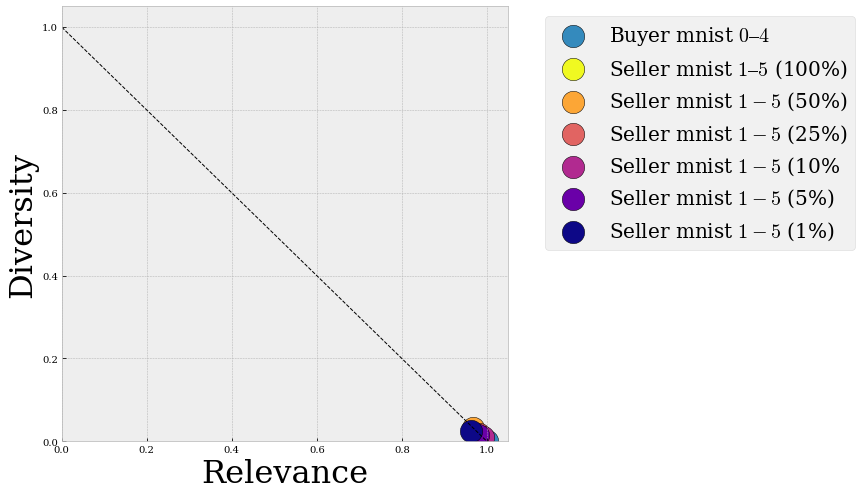

In [201]:
s = 500
plt.figure(figsize=(8, 8))

plt.scatter(*div_rel_func(buyer_values, buyer_components, buyer_cov, **kwargs),   edgecolor='k', s=s, label=r'Buyer mnist $0–4$')

plt.scatter(*div_rel_func(buyer_values, buyer_components, seller1_cov, **kwargs), c=plasma[0], edgecolor='k', s=s, label=r'Seller mnist $1–5$ (100%)')
plt.scatter(*div_rel_func(buyer_values, buyer_components, dup1_cov, **kwargs), c=plasma[1], edgecolor='k', s=s, label=r'Seller mnist $1-5$ (50%)')
plt.scatter(*div_rel_func(buyer_values, buyer_components, dup2_cov, **kwargs), c=plasma[2], edgecolor='k', s=s, label=r'Seller mnist $1-5$ (25%)')
plt.scatter(*div_rel_func(buyer_values, buyer_components, dup3_cov, **kwargs), c=plasma[3], edgecolor='k', s=s, label=r'Seller mnist $1-5$ (10%')
plt.scatter(*div_rel_func(buyer_values, buyer_components, dup4_cov, **kwargs), c=plasma[4], edgecolor='k', s=s, label=r'Seller mnist $1-5$ (5%)')
plt.scatter(*div_rel_func(buyer_values, buyer_components, dup5_cov, **kwargs), c=plasma[5], edgecolor='k', s=s, label=r'Seller mnist $1-5$ (1%)')


plt.xlim(0, 1.05)
plt.ylim(0, 1.05)
plt.plot(np.arange(0, 1.1, 0.1), 1 - np.arange(0, 1.1, 0.1), marker='', markersize = 4, markeredgewidth=1.5, color='black', linestyle='--', linewidth=1)
plt.xlabel('Relevance', fontsize=32)
plt.ylabel('Diversity', fontsize=32)
plt.legend(prop={'size': 20}, bbox_to_anchor=(1.80, 1.00))
plt.savefig(f'mnist-diversity-dup.png', bbox_inches='tight')
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

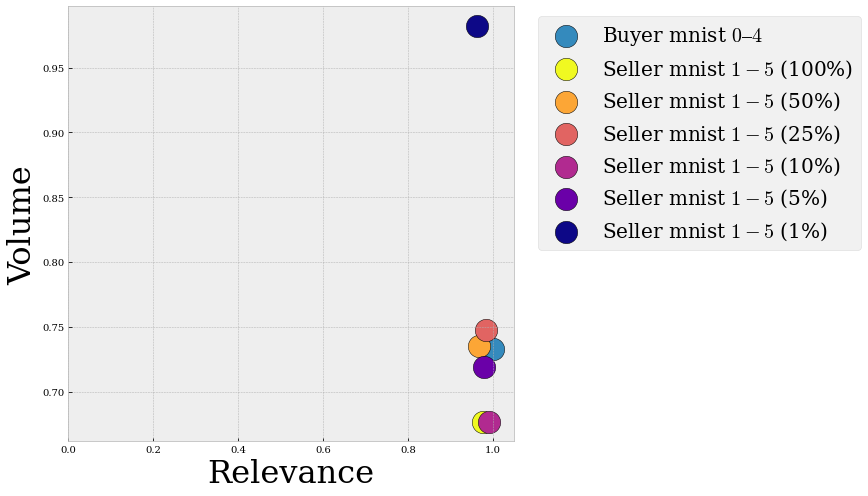

In [202]:
s = 500
plt.figure(figsize=(8, 8))
plt.scatter(div_rel_func(buyer_values, buyer_components, buyer_cov, **kwargs)[0],   buyer_vol,   edgecolor='k', s=s, label=r'Buyer mnist $0–4$')

plt.scatter(div_rel_func(buyer_values, buyer_components, seller1_cov, **kwargs)[0], seller1_vol, c=plasma[0], edgecolor='k', s=s, label=r'Seller mnist $1-5$ (100%)')
plt.scatter(div_rel_func(buyer_values, buyer_components, dup1_cov, **kwargs)[0], dup1_vol, c=plasma[1], edgecolor='k', s=s, label=r'Seller mnist $1-5$ (50%)')
plt.scatter(div_rel_func(buyer_values, buyer_components, dup2_cov, **kwargs)[0], dup2_vol, c=plasma[2], edgecolor='k', s=s, label=r'Seller mnist $1-5$ (25%)')
plt.scatter(div_rel_func(buyer_values, buyer_components, dup3_cov, **kwargs)[0], dup3_vol, c=plasma[3], edgecolor='k', s=s, label=r'Seller mnist $1-5$ (10%)')
plt.scatter(div_rel_func(buyer_values, buyer_components, dup4_cov, **kwargs)[0], dup4_vol, c=plasma[4], edgecolor='k', s=s, label=r'Seller mnist $1-5$ (5%)')
plt.scatter(div_rel_func(buyer_values, buyer_components, dup5_cov, **kwargs)[0], dup5_vol, c=plasma[5], edgecolor='k', s=s, label=r'Seller mnist $1-5$ (1%)')

plt.legend(prop={'size': 20}, bbox_to_anchor=(1.80, 1.00))
# plt.yscale('log',base=2) 
plt.xlim(0, 1.05)
# plt.ylim(0, 1.05)
plt.xlabel('Relevance', fontsize=32)
plt.ylabel('Volume', fontsize=32)
plt.savefig(f'mnist-volume-dup.png', bbox_inches='tight')
plt.show()


In [203]:
magma = [matplotlib.colormaps['magma'].colors[int(k)] for k in np.linspace(255, 0, 12)]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

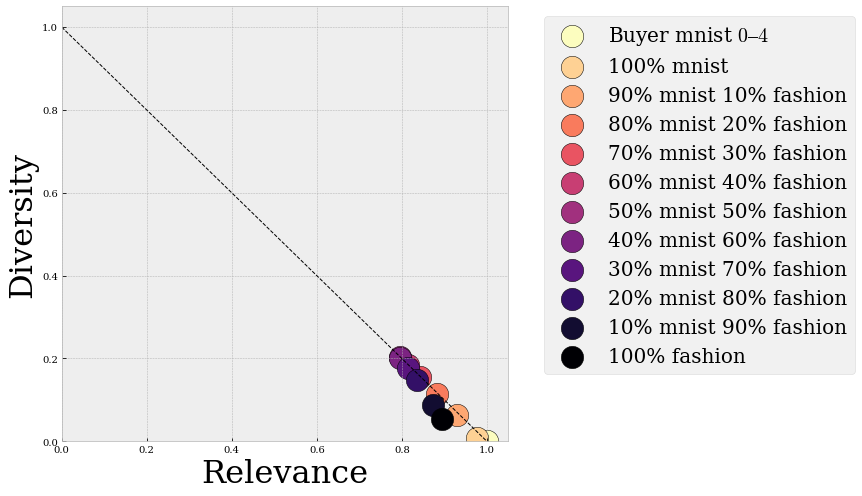

In [204]:

s = 500
plt.figure(figsize=(8, 8))

plt.scatter(*div_rel_func(buyer_values, buyer_components, buyer_cov, **kwargs),   c=magma[0], edgecolor='k', s=s, label=r'Buyer mnist $0–4$')

plt.scatter(*div_rel_func(buyer_values, buyer_components, seller1_cov, **kwargs), c=magma[1], edgecolor='k', s=s, label=r'100% mnist')
plt.scatter(*div_rel_func(buyer_values, buyer_components, mix1_cov, **kwargs), c=magma[2], edgecolor='k', s=s, label=r'90% mnist 10% fashion')
plt.scatter(*div_rel_func(buyer_values, buyer_components, mix2_cov, **kwargs), c=magma[3], edgecolor='k', s=s, label=r'80% mnist 20% fashion')
plt.scatter(*div_rel_func(buyer_values, buyer_components, mix3_cov, **kwargs), c=magma[4], edgecolor='k', s=s, label=r'70% mnist 30% fashion')
plt.scatter(*div_rel_func(buyer_values, buyer_components, mix4_cov, **kwargs), c=magma[5], edgecolor='k', s=s, label=r'60% mnist 40% fashion')
plt.scatter(*div_rel_func(buyer_values, buyer_components, mix5_cov, **kwargs), c=magma[6], edgecolor='k', s=s, label=r'50% mnist 50% fashion')
plt.scatter(*div_rel_func(buyer_values, buyer_components, mix6_cov, **kwargs), c=magma[7], edgecolor='k', s=s, label=r'40% mnist 60% fashion')
plt.scatter(*div_rel_func(buyer_values, buyer_components, mix7_cov, **kwargs), c=magma[8], edgecolor='k', s=s, label=r'30% mnist 70% fashion')
plt.scatter(*div_rel_func(buyer_values, buyer_components, mix8_cov, **kwargs), c=magma[9], edgecolor='k', s=s, label=r'20% mnist 80% fashion')
plt.scatter(*div_rel_func(buyer_values, buyer_components, mix9_cov, **kwargs), c=magma[10], edgecolor='k', s=s, label=r'10% mnist 90% fashion')
plt.scatter(*div_rel_func(buyer_values, buyer_components, seller_fashion_cov, **kwargs), c=magma[11], edgecolor='k', s=s, label=r'100% fashion')


plt.xlim(0, 1.05)
plt.ylim(0, 1.05)
plt.plot(np.arange(0, 1.1, 0.1), 1 - np.arange(0, 1.1, 0.1), marker='', markersize = 4, markeredgewidth=1.5, color='black', linestyle='--', linewidth=1)
plt.xlabel('Relevance', fontsize=32)
plt.ylabel('Diversity', fontsize=32)
plt.legend(prop={'size': 20}, bbox_to_anchor=(1.80, 1.00))
plt.savefig(f'mnist-diversity-mix.png', bbox_inches='tight')
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

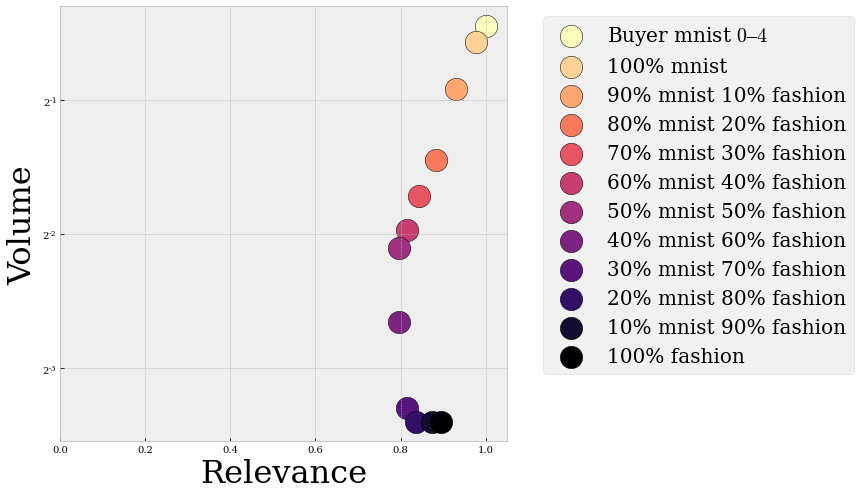

In [205]:
s = 500
plt.figure(figsize=(8, 8))
plt.scatter(div_rel_func(buyer_values, buyer_components, buyer_cov, **kwargs)[0],   buyer_vol,  c=magma[0], edgecolor='k', s=s, label=r'Buyer mnist $0–4$')

plt.scatter(div_rel_func(buyer_values, buyer_components, seller1_cov, **kwargs)[0], seller1_vol, c=magma[1], edgecolor='k', s=s, label=r'100% mnist')
plt.scatter(div_rel_func(buyer_values, buyer_components, mix1_cov, **kwargs)[0], mix1_vol, c=magma[2], edgecolor='k', s=s, label=r'90% mnist 10% fashion')
plt.scatter(div_rel_func(buyer_values, buyer_components, mix2_cov, **kwargs)[0], mix2_vol, c=magma[3], edgecolor='k', s=s, label=r'80% mnist 20% fashion')
plt.scatter(div_rel_func(buyer_values, buyer_components, mix3_cov, **kwargs)[0], mix3_vol, c=magma[4], edgecolor='k', s=s, label=r'70% mnist 30% fashion')
plt.scatter(div_rel_func(buyer_values, buyer_components, mix4_cov, **kwargs)[0], mix4_vol, c=magma[5], edgecolor='k', s=s, label=r'60% mnist 40% fashion')
plt.scatter(div_rel_func(buyer_values, buyer_components, mix5_cov, **kwargs)[0], mix5_vol, c=magma[6], edgecolor='k', s=s, label=r'50% mnist 50% fashion')
plt.scatter(div_rel_func(buyer_values, buyer_components, mix6_cov, **kwargs)[0], mix6_vol, c=magma[7], edgecolor='k', s=s, label=r'40% mnist 60% fashion')
plt.scatter(div_rel_func(buyer_values, buyer_components, mix7_cov, **kwargs)[0], mix7_vol, c=magma[8], edgecolor='k', s=s, label=r'30% mnist 70% fashion')
plt.scatter(div_rel_func(buyer_values, buyer_components, mix8_cov, **kwargs)[0], mix8_vol, c=magma[9], edgecolor='k', s=s, label=r'20% mnist 80% fashion')
plt.scatter(div_rel_func(buyer_values, buyer_components, mix9_cov, **kwargs)[0], mix9_vol, c=magma[10], edgecolor='k', s=s, label=r'10% mnist 90% fashion')

plt.scatter(div_rel_func(buyer_values, buyer_components, seller_fashion_cov, **kwargs)[0], seller_fashion_vol, c=magma[11], edgecolor='k', s=s, label=r'100% fashion')

plt.legend(prop={'size': 20}, bbox_to_anchor=(1.80, 1.00))
plt.yscale('log',base=2) 
plt.xlim(0, 1.05)
# plt.ylim(0, 1.05)
plt.xlabel('Relevance', fontsize=32)
plt.ylabel('Volume', fontsize=32)
plt.savefig(f'mnist-volume-mix.png', bbox_inches='tight')
plt.show()
